# Estudo da rede neural MLP como classificadora do dataset KMNIST

## Bibliotecas

In [1]:
import torch

In [2]:
#  Verificando a versão do PyTorch e se está usando GPU
print('Versão PyTorch: ', torch.__version__)
print('Usando GPU: ', torch.cuda.is_available())

if torch.cuda.is_available():    
    print('GPU: ',torch.cuda.get_device_name(torch.cuda.current_device()))

Versão PyTorch:  1.9.0+cu111
Usando GPU:  True
GPU:  NVIDIA GeForce GTX 1660 Ti with Max-Q Design


## Fixando os parâmetros para carregar as imagens

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch import optim

In [4]:
# Transform
transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Batch size
batch_size = 120

## Leitura dos dados

In [5]:
# Conjunto de treinamento
trainset = dsets.KMNIST(root='~/data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

In [6]:
# Conjunto de teste
testset = dsets.KMNIST(root='~/data', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

In [7]:
print(f"> {len(trainset)} amostras de Treino e {len(testset)} amostras de Teste")

> 60000 amostras de Treino e 10000 amostras de Teste


## Plotando algumas imagens

In [8]:
import matplotlib.pyplot as plt

In [9]:
labels_dict = {
    testloader.dataset.classes[0] : u"\u304A",
    testloader.dataset.classes[1] : u"\u304D",
    testloader.dataset.classes[2] : u"\u3059",
    testloader.dataset.classes[3] : u"\u3064",
    testloader.dataset.classes[4] : u"\u306A",
    testloader.dataset.classes[5] : u"\u306F",
    testloader.dataset.classes[6] : u"\u307E",
    testloader.dataset.classes[7] : u"\u3084",
    testloader.dataset.classes[8] : u"\u308C",
    testloader.dataset.classes[9] : u"\u3093"
}

In [42]:
labels_dict

{'o': 'お',
 'ki': 'き',
 'su': 'す',
 'tsu': 'つ',
 'na': 'な',
 'ha': 'は',
 'ma': 'ま',
 'ya': 'や',
 're': 'れ',
 'wo': 'ん'}

In [11]:
labels_dict2 = {
    0: "o",
    1: "ki",
    2: "su",
    3: "tsu",
    4: "na",
    5: "ha",
    6: "ma",
    7: "ya",
    8: "re",
    9: "wo"
}

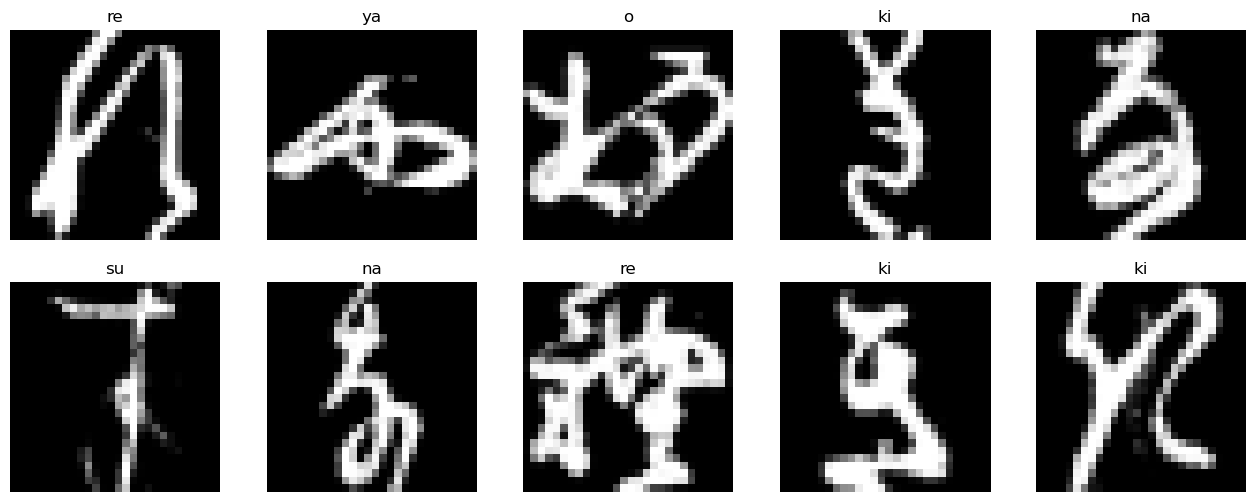

In [12]:
rows, columns = 2, 5

fig, axs = plt.subplots(rows, columns, figsize=(16,6))
for i in range(rows):
    for j in range(columns):
        k = 5*i + j
        axs[i,j].imshow(trainset[k][0].reshape(28,28), cmap=plt.get_cmap("gray"))
        axs[i,j].set_title(labels_dict2[trainset[k][1]])
        axs[i,j].axis("off")
        axs[i,j].set_aspect("equal")

plt.show()

## Criando a rede

In [13]:
import torch.nn.functional as F
from torch import nn

In [14]:
class ClassifierDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,196)
        self.fc2 = nn.Linear(196,196)
#         self.fc3 = nn.Linear(196,196)
        self.fc4 = nn.Linear(196,49)
        self.fc5 = nn.Linear(49,10)
        
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
#         x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

## Fixando os hiperparâmetros

In [15]:
model = ClassifierDropout()

# Learning rate
learning_rate = 0.1
# Optimizer
optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
# Criterion
criterion = torch.nn.CrossEntropyLoss()
# Epoch
epochs = 15

## Treinando a rede

In [16]:
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for image, label in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(image)
        loss = criterion(log_ps, label)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for image, label in testloader:         
                
                log_ps = model.forward(image)
                prob = torch.exp(log_ps)
                
                test_loss+= criterion(log_ps, label)
                k_prob, k_class = prob.topk(1, dim=1)
                equals = k_class == label.view(*k_class.shape)
                
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/15..  Training Loss: 0.946..  Test Loss: 0.796..  Test Accuracy: 0.743
Epoch: 2/15..  Training Loss: 0.401..  Test Loss: 0.585..  Test Accuracy: 0.817
Epoch: 3/15..  Training Loss: 0.294..  Test Loss: 0.525..  Test Accuracy: 0.835
Epoch: 4/15..  Training Loss: 0.239..  Test Loss: 0.496..  Test Accuracy: 0.852
Epoch: 5/15..  Training Loss: 0.202..  Test Loss: 0.452..  Test Accuracy: 0.864
Epoch: 6/15..  Training Loss: 0.173..  Test Loss: 0.420..  Test Accuracy: 0.871
Epoch: 7/15..  Training Loss: 0.154..  Test Loss: 0.396..  Test Accuracy: 0.885
Epoch: 8/15..  Training Loss: 0.136..  Test Loss: 0.411..  Test Accuracy: 0.879
Epoch: 9/15..  Training Loss: 0.124..  Test Loss: 0.421..  Test Accuracy: 0.881
Epoch: 10/15..  Training Loss: 0.112..  Test Loss: 0.379..  Test Accuracy: 0.894
Epoch: 11/15..  Training Loss: 0.103..  Test Loss: 0.406..  Test Accuracy: 0.889
Epoch: 12/15..  Training Loss: 0.092..  Test Loss: 0.386..  Test Accuracy: 0.896
Epoch: 13/15..  Training Loss: 0.087.

---

## Avaliando a rede

### Gráfico de convergência

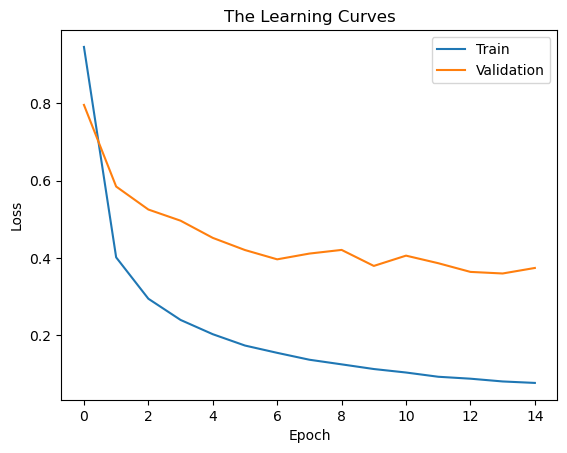

In [17]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend()

plt.title('The Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

### Amostra da probabilidade

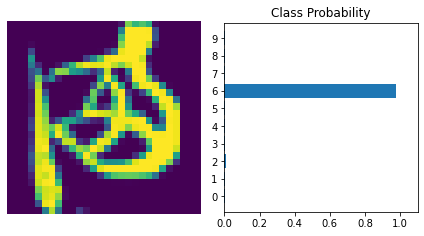

In [18]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# desligando o gradiente para acelerar o processo
with torch.no_grad():
    logps = model(img)

# As saidas da rede são o log da probabilidade.
# Por isso precisamos fazer o exponencial para termos as probabilidades reais.
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

### Acurácia

In [19]:
import pandas as pd
from torch.autograd import Variable

In [20]:
predicted = []
expected = []

for image, label in testset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [21]:
results = pd.DataFrame({'predicted': predicted, 'expected': expected})
results

,predicted,expected
0,3,2
1,9,9
2,3,3
3,8,8
4,3,3
...,...,...
9995,4,4
9996,0,0
9997,9,9
9998,4,4


In [22]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.8847


### Matriz de confusão

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

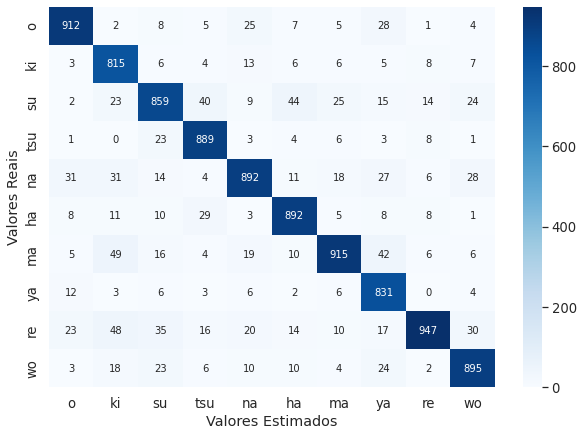

In [24]:
cm = confusion_matrix(predicted, expected)

df_cm = pd.DataFrame(cm)
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valores Estimados"

plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True, 
    fmt="d", 
    annot_kws={"size": 10}, 
    xticklabels=testloader.dataset.classes,
    yticklabels=testloader.dataset.classes
)

plt.show()

In [25]:
Pára!!!

SyntaxError: invalid syntax (<ipython-input-25-905716ceefeb>, line 1)

---

# Teste da rede sem `dropout`

## Criando a rede

In [26]:
import torch.nn.functional as F
from torch import nn

In [27]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,196)
        self.fc2 = nn.Linear(196,196)
#         self.fc3 = nn.Linear(196,196)
        self.fc4 = nn.Linear(196,49)
        self.fc5 = nn.Linear(49,10)
        
    def forward(self, x):
        # certificar que o tensor com as imagens foi 'achatado'
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

## Fixando os hiperparâmetros

In [28]:
model = Classifier()

# Learning rate
learning_rate = 0.1
# Optimizer
optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
# Criterion
criterion = torch.nn.CrossEntropyLoss()
# Epoch
epochs = 15

## Treinando a rede

In [29]:
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        # else pode ser usado em laços tipo for no python, e só será executado se não cair em nenhum break
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            # passo de validação
            for images, labels in testloader:
                log_ps = model(images)
                ps = torch.exp(log_ps)
                
                test_loss += criterion(log_ps, labels)  
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
                
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/15..  Training Loss: 0.880..  Test Loss: 0.767..  Test Accuracy: 0.752
Epoch: 2/15..  Training Loss: 0.337..  Test Loss: 0.605..  Test Accuracy: 0.809
Epoch: 3/15..  Training Loss: 0.237..  Test Loss: 0.517..  Test Accuracy: 0.844
Epoch: 4/15..  Training Loss: 0.185..  Test Loss: 0.476..  Test Accuracy: 0.860
Epoch: 5/15..  Training Loss: 0.147..  Test Loss: 0.435..  Test Accuracy: 0.873
Epoch: 6/15..  Training Loss: 0.118..  Test Loss: 0.411..  Test Accuracy: 0.885
Epoch: 7/15..  Training Loss: 0.101..  Test Loss: 0.430..  Test Accuracy: 0.880
Epoch: 8/15..  Training Loss: 0.083..  Test Loss: 0.401..  Test Accuracy: 0.892
Epoch: 9/15..  Training Loss: 0.069..  Test Loss: 0.394..  Test Accuracy: 0.898
Epoch: 10/15..  Training Loss: 0.057..  Test Loss: 0.430..  Test Accuracy: 0.892
Epoch: 11/15..  Training Loss: 0.047..  Test Loss: 0.411..  Test Accuracy: 0.900
Epoch: 12/15..  Training Loss: 0.040..  Test Loss: 0.420..  Test Accuracy: 0.899
Epoch: 13/15..  Training Loss: 0.032.

---

## Avaliando a rede

### Gráfico de convergência

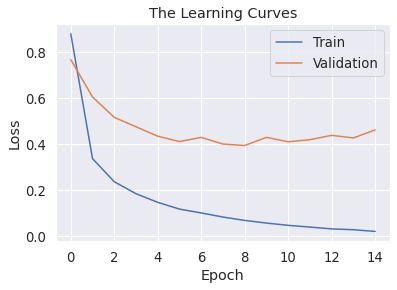

In [39]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend()

plt.title('The Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

### Amostra da probabilidade

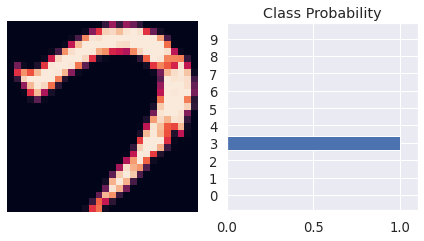

In [31]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# desligando o gradiente para acelerar o processo
with torch.no_grad():
    logps = model(img)

# As saidas da rede são o log da probabilidade.
# Por isso precisamos fazer o exponencial para termos as probabilidades reais.
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

### Acurácia

In [32]:
import pandas as pd
from torch.autograd import Variable

In [33]:
predicted = []
expected = []

for image, label in testset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [34]:
results = pd.DataFrame({'predicted': predicted, 'expected': expected})
results

,predicted,expected
0,1,2
1,9,9
2,3,3
3,8,8
4,3,3
...,...,...
9995,4,4
9996,0,0
9997,9,9
9998,4,4


In [35]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.9016


### Matriz de confusão

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

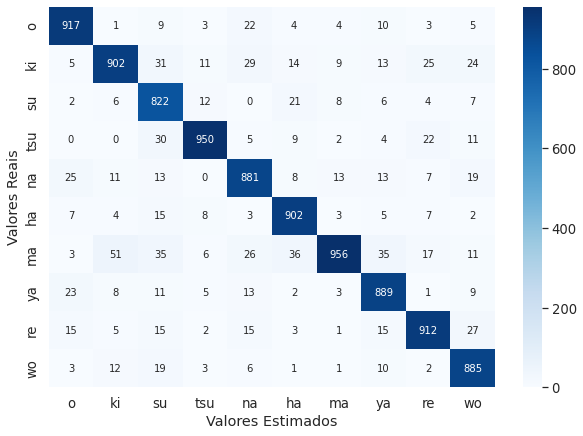

In [37]:
cm = confusion_matrix(predicted, expected)

df_cm = pd.DataFrame(cm)
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valores Estimados"

plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True, 
    fmt="d", 
    annot_kws={"size": 10}, 
    xticklabels=testloader.dataset.classes,
    yticklabels=testloader.dataset.classes
)

plt.show()